# Chrome Dino environment development
![](http://www.skipser.com/test/trex-game/promotion/trex-chrome-game.png)

In [1]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

Game is available at https://chromedino.com/

##### Summary
- Capturing image from the game
- Allowing control programmatically
- Trying a simple implementation with classic CV algorithms
- Capturing score as image and detect them as digits to keep track of the scores for training
- Creating a genetic algorithm with the raw images captured
- Creating a genetic algorithm with the processed images
- Initialize the agent with hard coded policy

##### Additional content
- Forcing size to ensure compatibility
- Using the framework to have multiple games at the same time ?


##### References
- https://docs.opencv.org/3.1.0/dd/d3b/tutorial_py_svm_opencv.html
- https://pythonprogramming.net/loading-images-python-opencv-tutorial/
- [OpenCV doc](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html)

***
# Capturing image from the game

In [5]:
import cv2
from PIL import Image,ImageGrab

##### Test with imagegrab
Image grab takes a bounding box with coordinates ``left,top,right,bottom``

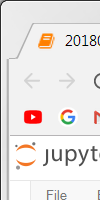

In [15]:
ImageGrab.grab(bbox=(0,0,100,200))

###### Get screen size

In [16]:
def get_size():
    img = ImageGrab.grab()
    return img.size
get_size()

(1920, 1080)

In [18]:
1920/2

960.0

##### Get ROI (Region Of Interest)

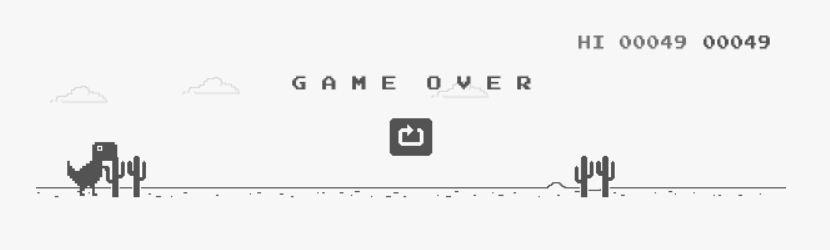

In [47]:
def grab_roi():
    return ImageGrab.grab(bbox=(1020,350,1850,600))

grab_roi()

***
# Allowing control programmatically
http://pyautogui.readthedocs.io/en/latest/keyboard.html

In [39]:
import pyautogui
import time
import random

###### Pressing up

In [40]:
pyautogui.press("up")

##### Planning multiple presses

In [42]:
t = time.time()
while time.time() - t < 3:
    print("UP")
    time.sleep(random.random()*2)
    pyautogui.press("up")

UP
UP
UP
UP
UP
UP


##### Moving mouse to other screen

In [44]:
pyautogui.click(x=1000,y = 500)
time.sleep(1)
pyautogui.press("up")

##### Random game for 10s

In [46]:
t = time.time()
pyautogui.click(x=1000,y = 500)
while time.time() - t < 10:
    print("UP")
    time.sleep(random.random()*2)
    pyautogui.press("up")

UP
UP
UP
UP
UP
UP
UP
UP
UP


***
# Try a simple implementation with classic CV algorithms

## Preparing the preprocessing

##### Capturing a sample image of the game

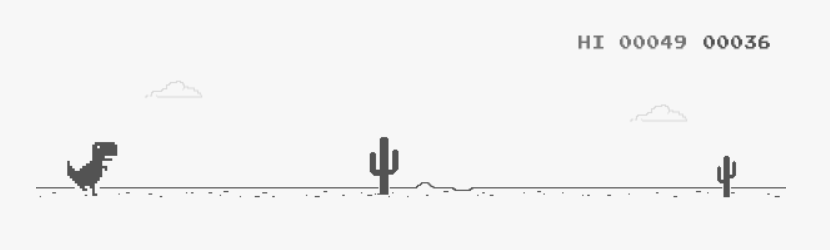

In [48]:
img = grab_roi()
img

##### Saving for further use

In [49]:
img.save("capture1.png")

In [50]:
img = Image.open("capture1.png")

In [53]:
img_array = np.array(img)

##### Detecting edges

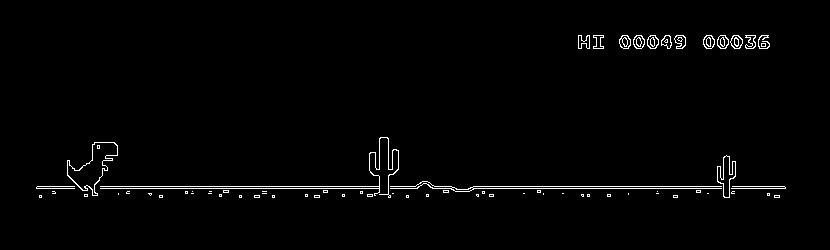

In [107]:
img_edges = cv2.Canny(img_array,100,200)
Image.fromarray(img_edges)

##### Applying a mask

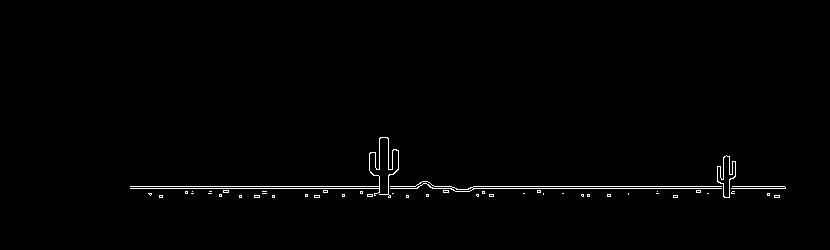

In [134]:
def select_part_from_mask(img):
    mask = np.zeros_like(img)
    mask[80:220,130:800] = 255
    masked = cv2.bitwise_and(img,mask)
    return masked

img_mask = select_part_from_mask(img_edges)
Image.fromarray(img_mask)

##### Morphological transformations to extract positions

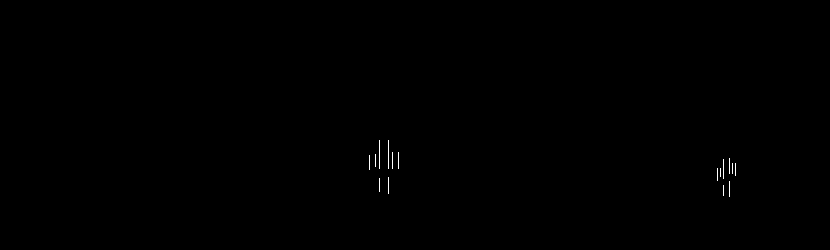

In [135]:
img_eroded = cv2.erode(img_mask,np.ones((4,1),np.uint8))
Image.fromarray(img_eroded)

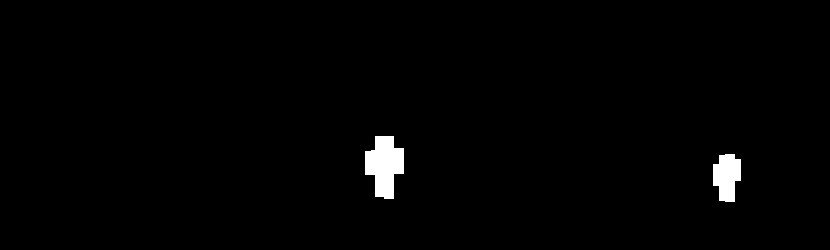

In [136]:
img_dilated = cv2.dilate(img_eroded,np.ones((10,10),np.uint8))
Image.fromarray(img_dilated)

##### Finding contours

In [160]:
im,contours,_ = cv2.findContours(img_dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

In [161]:
print(im.shape)
im = cv2.cvtColor(im,cv2.COLOR_GRAY2BGR)
print(im.shape)

(250, 830)
(250, 830, 3)


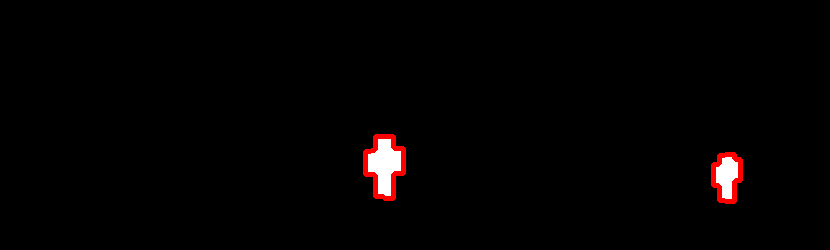

In [162]:
cv2.drawContours(im, contours, -1, (255,0,0), 3)
Image.fromarray(im)

##### Extracting left positions from contours

In [164]:
len(contours)

2

In [173]:
contours[0].min(axis = 0)[0][0]

713

In [174]:
contours[1].min(axis = 0)[0][0]

365

In [175]:
im.shape

(250, 830, 3)

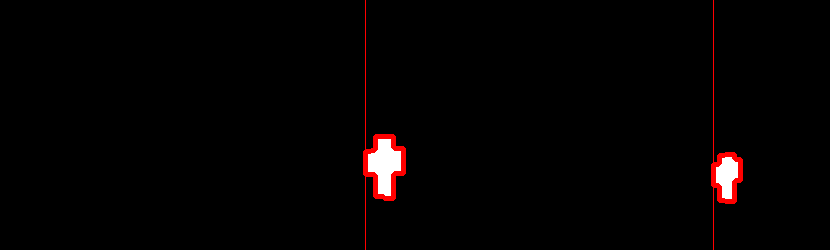

In [179]:
im2 = im.copy()
cv2.line(im2,(365,0),(365,250),(255,0,0),1)
cv2.line(im2,(713,0),(713,250),(255,0,0),1)
Image.fromarray(im2)

## Combine all the steps in a processing function

In [182]:
def process_input(img):
    img_array = np.array(img)
    img_edges = cv2.Canny(img_array,100,200)
    img_mask = select_part_from_mask(img_edges)
    img_eroded = cv2.erode(img_mask,np.ones((4,1),np.uint8))
    img_dilated = cv2.dilate(img_eroded,np.ones((10,10),np.uint8))
    img_contours,contours,_ = cv2.findContours(img_dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    img_contours = cv2.cvtColor(img_contours,cv2.COLOR_GRAY2BGR)
    cv2.drawContours(img_contours, contours, -1, (255,0,0), 3)
    img_lines = img_contours.copy()
    xs = list(sorted([y.min(axis = 0)[0][0] for y in contours]))
    for x in xs:
        cv2.line(img_lines,(x,0),(x,img_lines.shape[0]),(255,0,0),1)
    return img_lines,xs

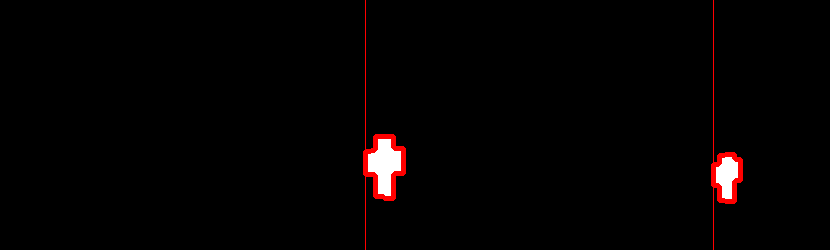

In [183]:
img_lines,xs = process_input(img)
Image.fromarray(img_lines)

In [184]:
xs

[365, 713]

##### Test with another sample image

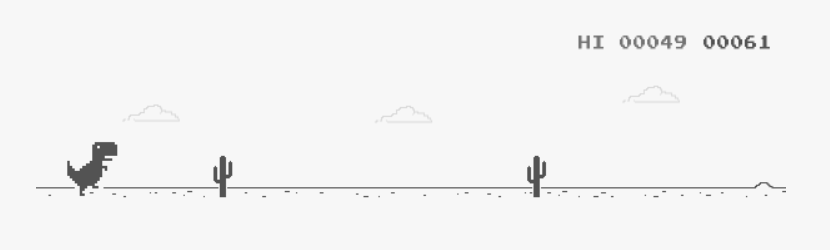

In [185]:
img2 = grab_roi()
img2

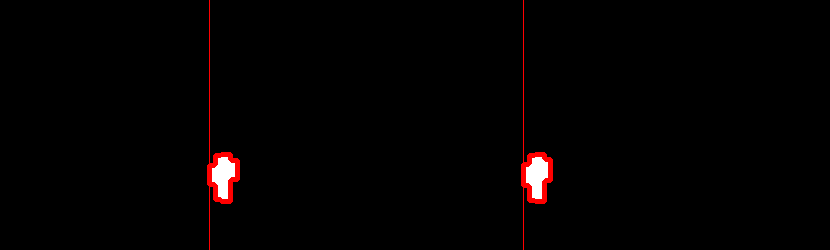

In [186]:
Image.fromarray(process_input(img2)[0])

## Use the boundaries to create the hard coded Agent

##### Game routine

In [191]:
t = time.time()
pyautogui.click(x=1000,y = 500)
while True:
    time.sleep(0.05)
    roi = grab_roi()
    roi_processed,xs = process_input(roi)
    if len(xs) > 0 and xs[0] < 300:
        pyautogui.press("up")

KeyboardInterrupt: 

##### First conclusions

- This hard coded agent works already pretty well. <br>
- Without spending a lot of time fine tuning the parameters, it can already avoid most of the cactuses till at least 400 points. <br>
- You can see a game example below
![](dino_hardcoded_agent.gif)

However, there are multiple problems with this approach : 
- The dinosaur **has trouble to plan ahead** and is only considering the first cactus to choose when to jump. This can cause problem when ideally we would want to jump a little ahead to have space for the second cactus. However, we could still create a more complicated rule to consider this situation 
- The dinosaur only knows **how to jump, and not how to duck**, this can be a problem when birds will appear after in the game. 
- Moreover, as the agent is not strong enought to reach the birds level. We don't have yet any images to tune our processing to find birds in the image. 
- Finally, the agent does not react differently to speed going up while playing

##### In a nutshell
- We could still improve this hard coded agent to be even better, but this is not the purpose of this project
- However, this is a good baseline to know how far we can go with rules in this game : around 500 points
- We could even initialize our reinforcement learning agents to the hard coded policy to skip the first training part of our agent